In [2]:
from joblib import Parallel, delayed
import math
import numpy as np
import time

In [65]:
def sqrt_func(i, j, toprint):
    #time.sleep(1)
    print(toprint)
    return math.sqrt(i)

output = np.zeros((3, 3))*np.nan
tic = time.time()
output= Parallel(n_jobs=3)(delayed(sqrt_func)(i, j, 'hello') for i in range(3) for j in range(3))
toc = time.time()
print(toc-tic, output)

output = np.zeros((3,3))*np.nan
tic = time.time()

for i in range(3):
    for j in range(3):
        output[i,j] = sqrt_func(i,j, 'heya')
toc = time.time()
print(toc-tic, output)

0.010566473007202148 [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951]
heya
heya
heya
heya
heya
heya
heya
heya
heya
0.0007081031799316406 [[0.         0.         0.        ]
 [1.         1.         1.        ]
 [1.41421356 1.41421356 1.41421356]]


In [22]:
# goal: fill a matrix in parallel

a = np.random.rand(100,150)
print(a)

tic = time.time()
b = np.zeros(a.shape)
for ii in range(100):
    for jj in range(150):
        b[ii,jj] = a[ii,jj]*3
toc = time.time()
print(toc-tic)


def atimesn(i, j, n, a):
    a[i,j] = a[i,j]*n
    return a[i,j]
tic = time.time()
a = Parallel(n_jobs=1)(delayed(atimesn)(i, j, 3, a) for i in range(100) for j in range(150))
toc = time.time()

print(toc-tic)

[[0.29632754 0.85809642 0.5003992  ... 0.66104633 0.18483723 0.03739758]
 [0.78167938 0.30880677 0.60006381 ... 0.36166256 0.40665307 0.43005433]
 [0.69985889 0.23145076 0.81360295 ... 0.94400893 0.87737625 0.75520094]
 ...
 [0.4808339  0.75190286 0.00856728 ... 0.33624371 0.77668306 0.38334342]
 [0.36958523 0.9126879  0.76110027 ... 0.45860426 0.53728526 0.76234548]
 [0.7964745  0.87267056 0.39583691 ... 0.01494743 0.91329811 0.83098021]]
0.00981283187866211
0.47972679138183594


In [32]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')
import itertools
import multiprocessing

In [18]:
# load in the polygons and attributes
fire_polygons = gpd.read_file('fire_polygons_only.geojson')
fire_attributes = pd.read_csv('fire_polygons_attributes.csv')
incidents = pd.read_csv('unique_fires.csv')
print(len(fire_polygons), len(fire_attributes), len(incidents))

#throw out fires that have 0 days with detects
daily_drop_inds = []
incident_drop_inds = []
for item in incidents['Incident Number']:
    pts = fire_attributes['Number of VIIRS points'].values[fire_attributes['Incident Number']==item]
    if len(pts[pts==0])==len(pts):
        #print(item, 'oops all zeros')
        daily_drop_inds = np.append(daily_drop_inds, np.where(fire_attributes['Incident Number']==item)[0])
        incident_drop_inds = np.append(incident_drop_inds, np.where(incidents['Incident Number']==item)[0])

daily_drop_inds = [int(p) for p in daily_drop_inds]
#print(daily_drop_inds)

fire_attributes = fire_attributes.drop(labels= daily_drop_inds)
fire_polygons = fire_polygons.drop(labels = daily_drop_inds)
incidents = incidents.drop(labels = incident_drop_inds)
print(len(fire_polygons), len(fire_attributes), len(incidents))

keep_days = []
for item in incidents['Incident Number']:
    pts = fire_attributes['Number of VIIRS points'].values[fire_attributes['Incident Number']==item]
    dys = fire_attributes['Current Day'].values[fire_attributes['Incident Number']==item]
    nonzero = np.where(pts!=0)[0]
    first_day = dys[nonzero[0]]
    last_day = dys[nonzero[len(nonzero)-1]]
    keep_days = np.append(keep_days, np.where((fire_attributes['Incident Number']==item)&(fire_attributes['Current Day']>=first_day)&(fire_attributes['Current Day']<=last_day))[0])

keep_days = [int(p) for p in keep_days]
print(len(keep_days))
fire_attributes = fire_attributes.iloc[keep_days, :]
fire_polygons = fire_polygons.iloc[keep_days, :]

fire_polygons

22280 22280 1354
19137 19137 1036
8161


geometry
5      POLYGON ((-112.75455 33.78632, -112.76012 33.7...
22     POLYGON ((-105.73275 33.80235, -105.73861 33.8...
23     POLYGON ((-105.73275 33.80235, -105.73861 33.8...
24     POLYGON ((-105.73275 33.80235, -105.73861 33.8...
25     POLYGON ((-105.73275 33.80235, -105.73861 33.8...
...                                                  ...
22271  POLYGON ((-112.11669 34.11898, -112.12564 34.1...
22272  POLYGON ((-117.03702 33.90632, -117.04484 33.9...
22274  POLYGON ((-117.27595 33.37881, -117.27495 33.3...
22275  POLYGON ((-117.29549 33.36558, -117.29713 33.4...
22279  POLYGON ((-117.27595 33.37881, -117.26967 33.4...

[8161 rows x 1 columns]

442
2019 02 17
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190217.nc4
(-114.461533, 32.829708, -114.445518, 32.874176)


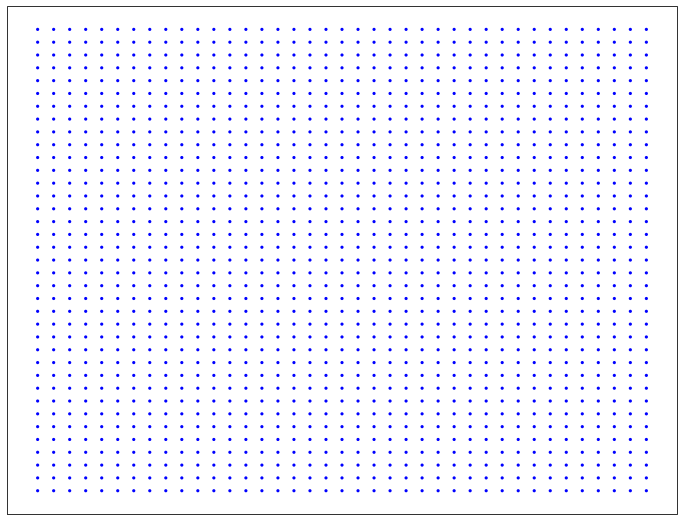

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190217.nc4
(-114.461533, 32.829708, -114.445518, 32.874176)


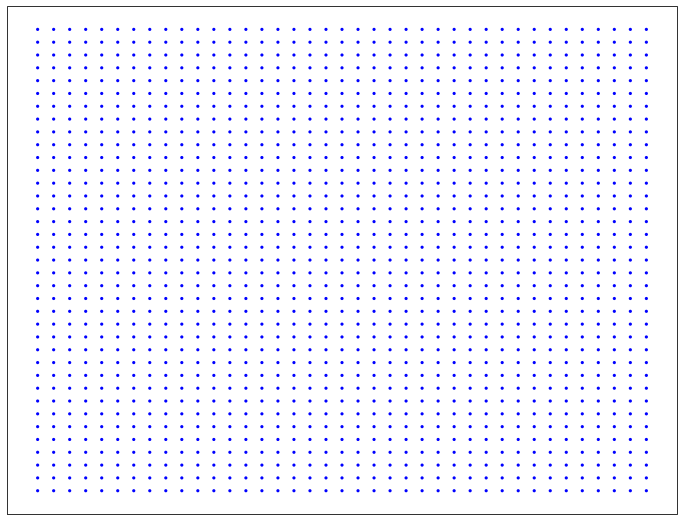

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190217.nc4
(-114.461533, 32.829708, -114.445518, 32.874176)


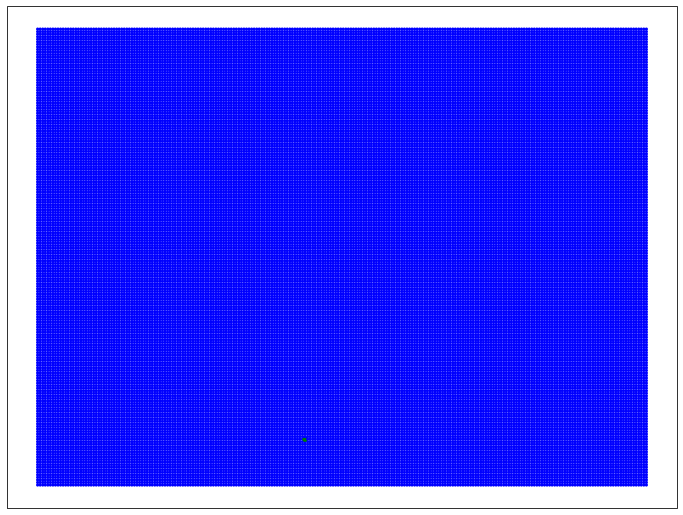

2019 02 18
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190218.nc4
(-114.462616, 32.829357, -114.445518, 32.874176)


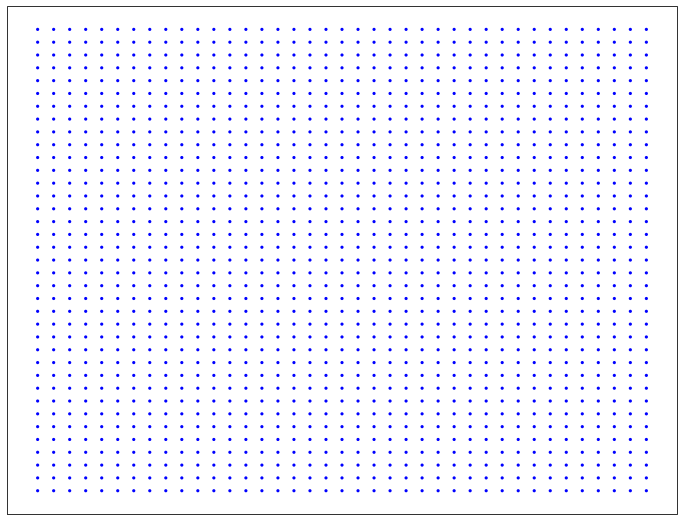

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190218.nc4
(-114.462616, 32.829357, -114.445518, 32.874176)


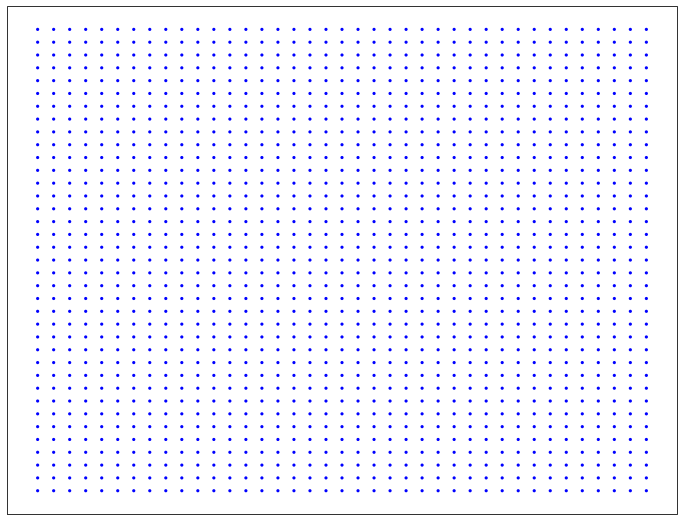

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190218.nc4
(-114.462616, 32.829357, -114.445518, 32.874176)


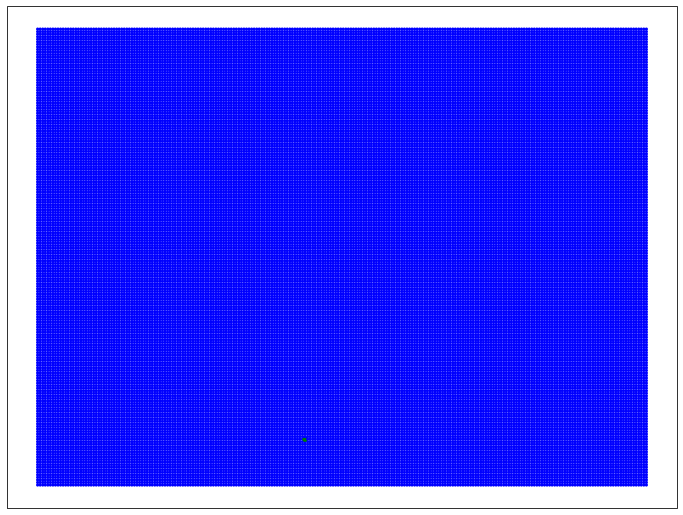

2019 02 24
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190224.nc4
(-104.414459, 40.698685, -104.413666, 40.720673)


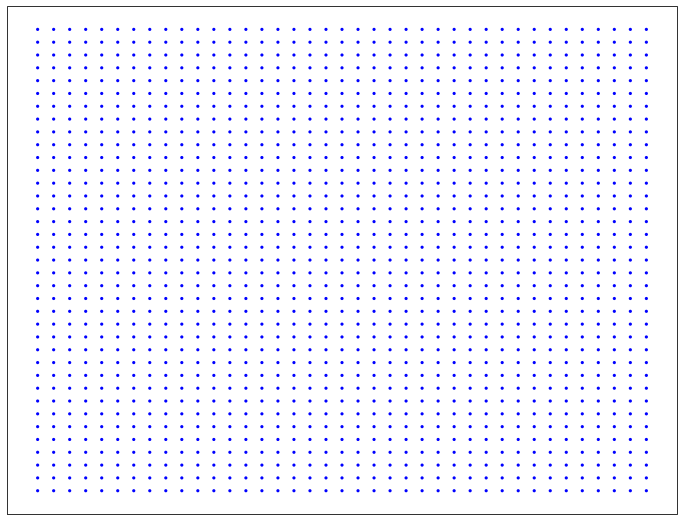

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190224.nc4
(-104.414459, 40.698685, -104.413666, 40.720673)


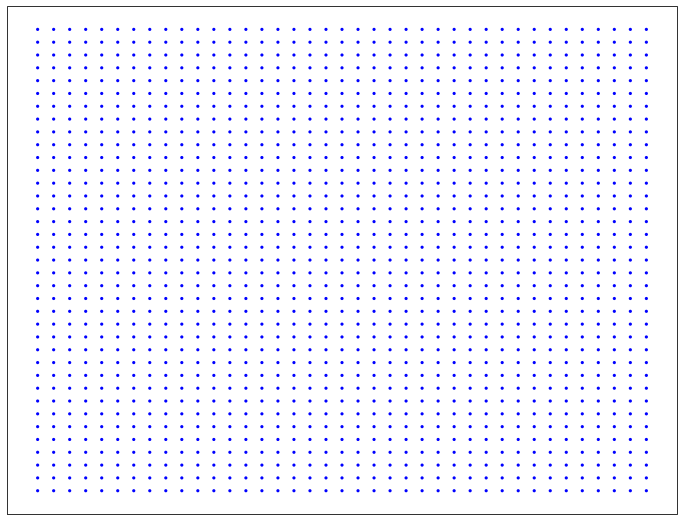

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190224.nc4
(-104.414459, 40.698685, -104.413666, 40.720673)


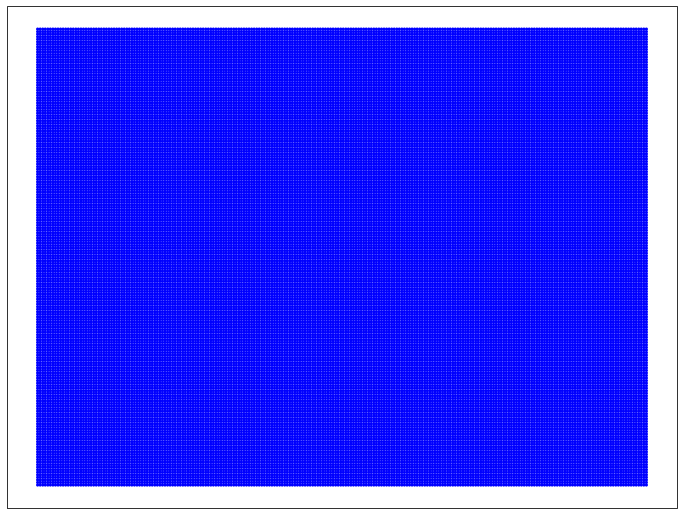

2019 03 06
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190306.nc4
(-110.713005, 31.335068, -110.701279, 31.342438)


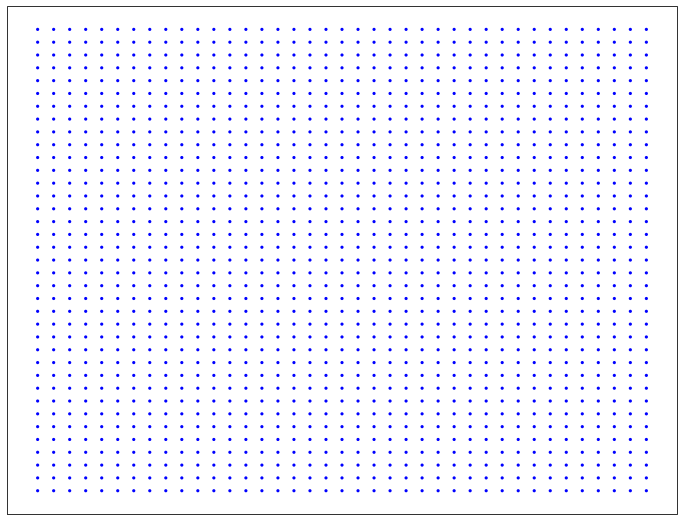

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190306.nc4
(-110.713005, 31.335068, -110.701279, 31.342438)


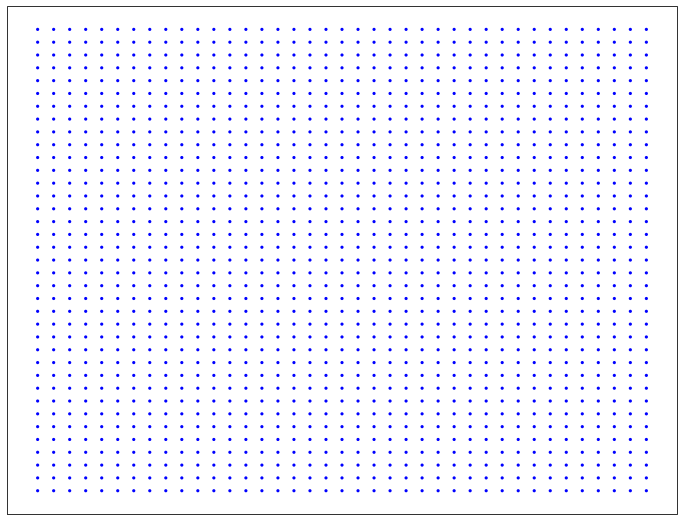

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190306.nc4
(-110.713005, 31.335068, -110.701279, 31.342438)


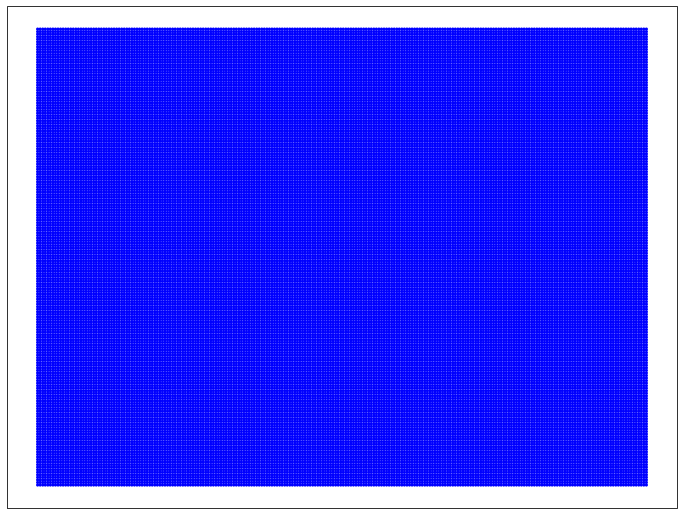

2019 03 13
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190313.nc4
(-101.637276, 35.739967, -101.56723, 35.790611)


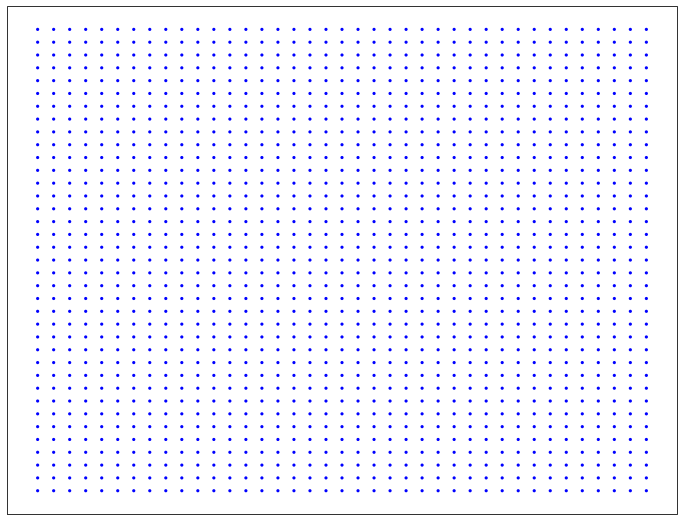

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190313.nc4
(-101.637276, 35.739967, -101.56723, 35.790611)


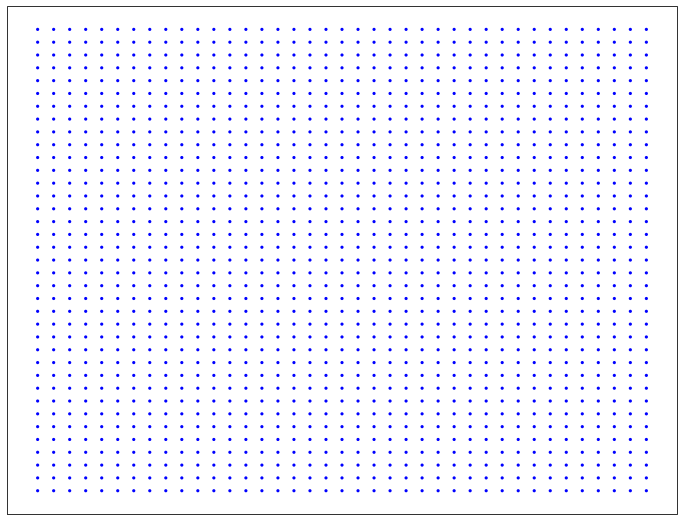

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190313.nc4
(-101.637276, 35.739967, -101.56723, 35.790611)


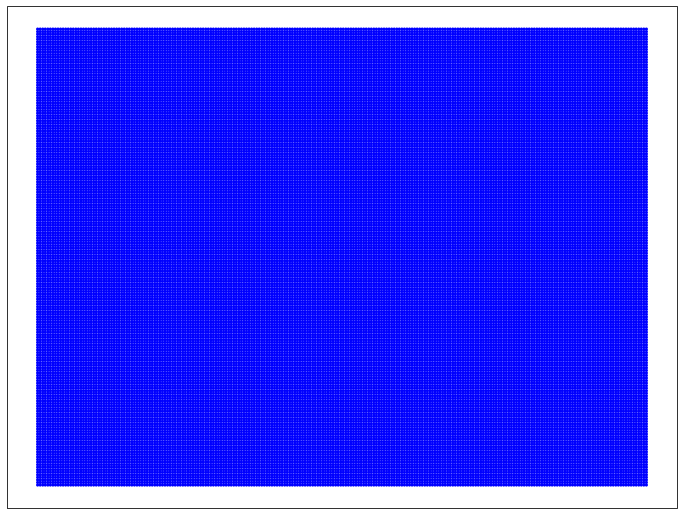

2019 03 15
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190315.nc4
(-116.083313, 33.542473, -116.054642, 33.549805)


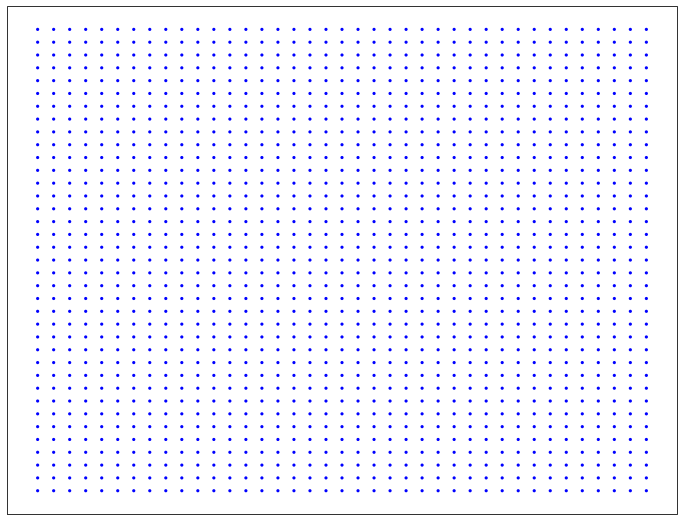

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190315.nc4
(-116.083313, 33.542473, -116.054642, 33.549805)


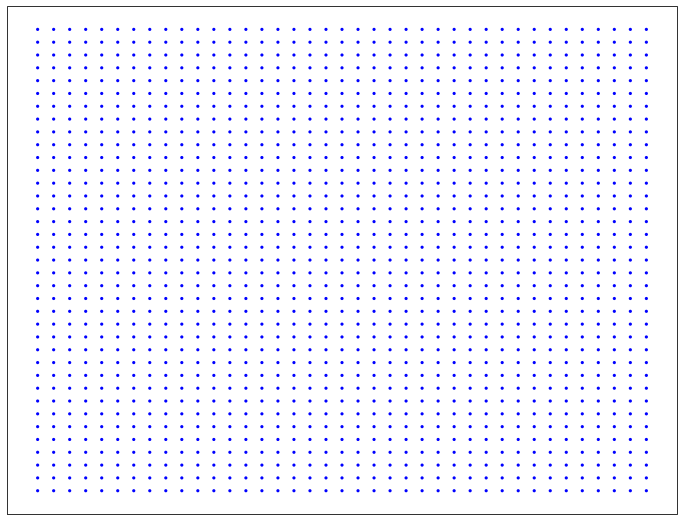

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190315.nc4
(-116.083313, 33.542473, -116.054642, 33.549805)


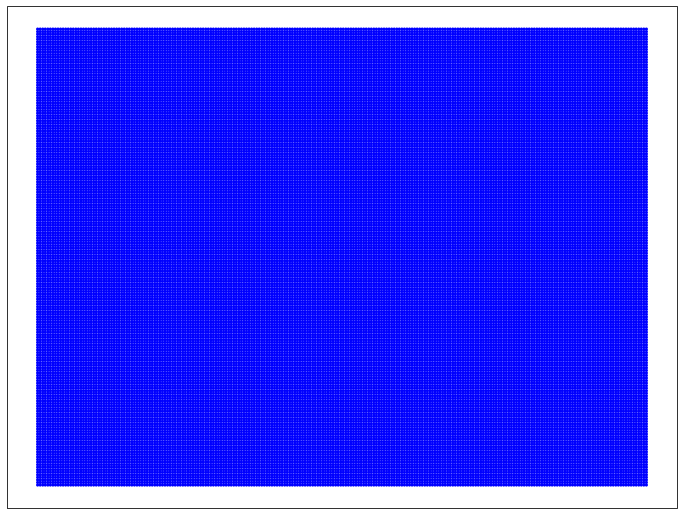

2019 03 16
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190316.nc4
(-116.082832, 33.532684, -116.071266, 33.548492)


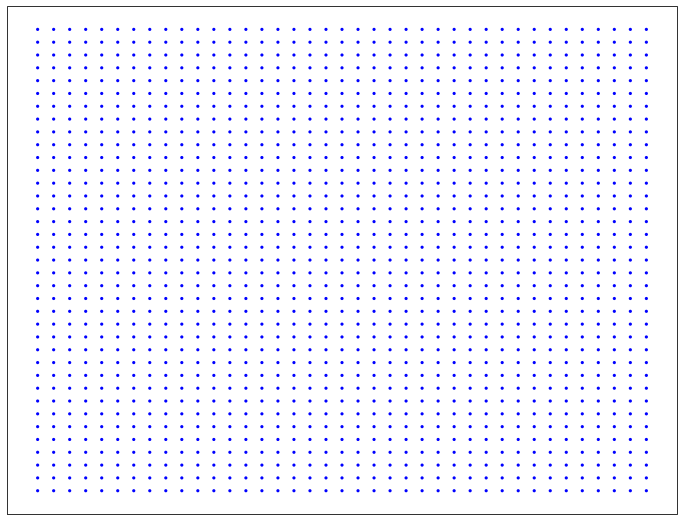

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190316.nc4
(-116.082832, 33.532684, -116.071266, 33.548492)


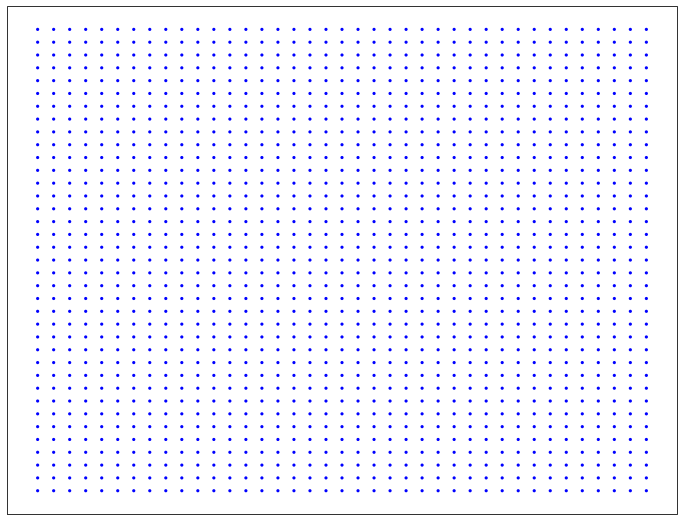

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190316.nc4
(-116.082832, 33.532684, -116.071266, 33.548492)


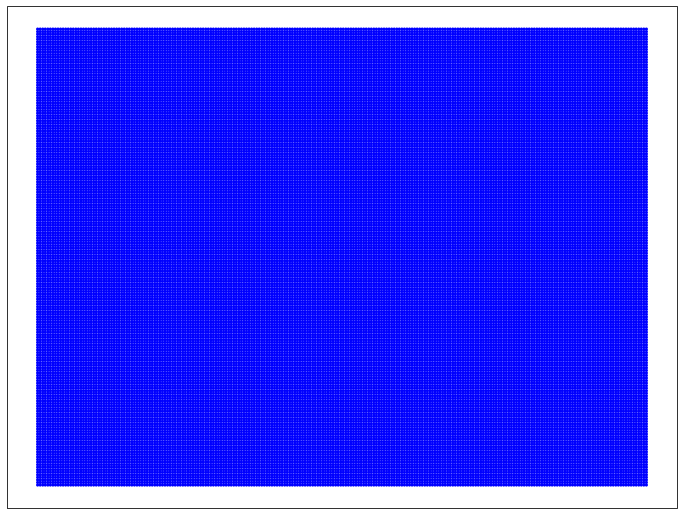

2019 03 17
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190317.nc4
(-116.074791, 33.534698, -116.064819, 33.546322)


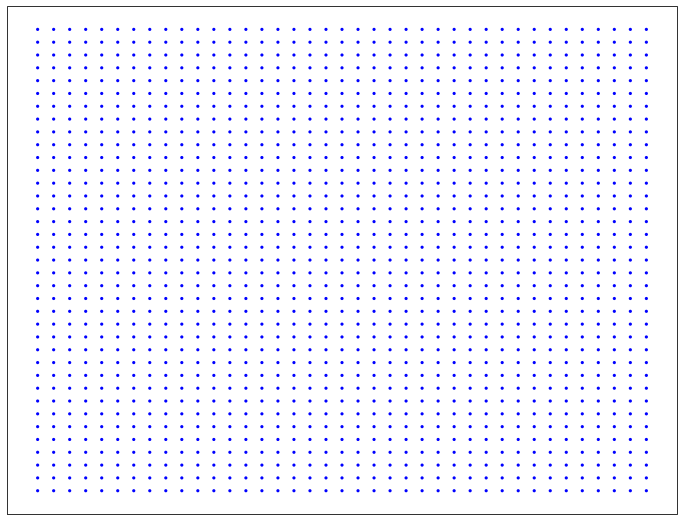

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190317.nc4
(-116.074791, 33.534698, -116.064819, 33.546322)


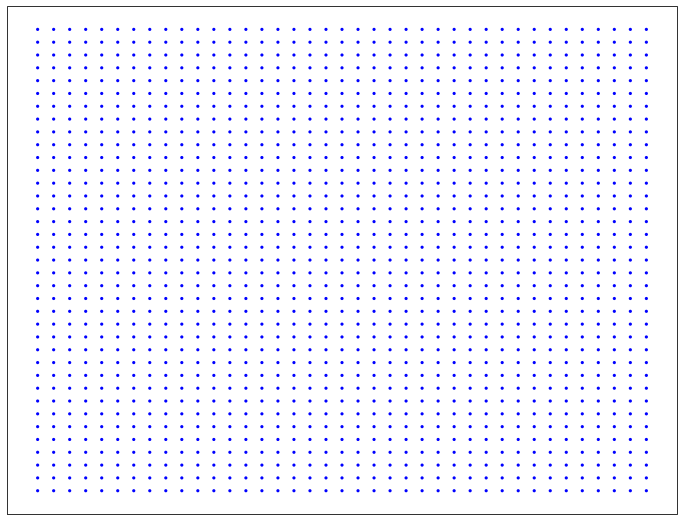

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190317.nc4
(-116.074791, 33.534698, -116.064819, 33.546322)


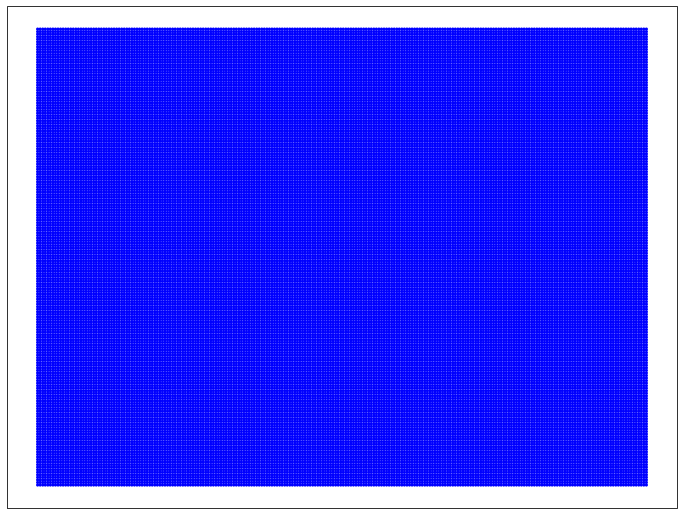

2019 03 18
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190318.nc4
(-116.075294, 33.534698, -116.064819, 33.546322)


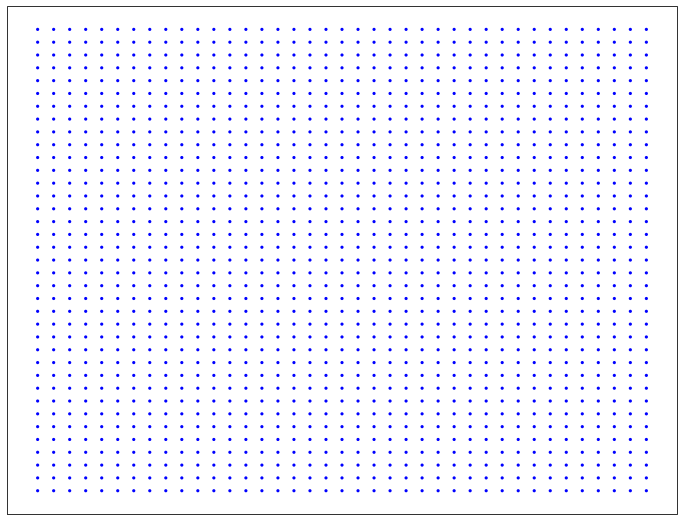

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190318.nc4
(-116.075294, 33.534698, -116.064819, 33.546322)


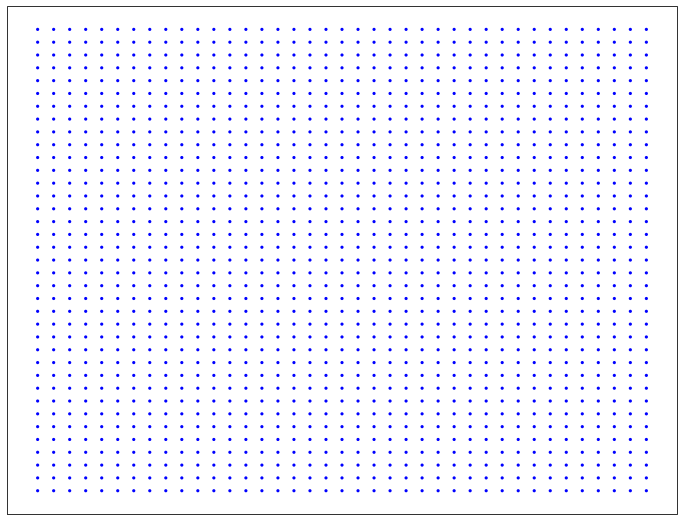

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190318.nc4
(-116.075294, 33.534698, -116.064819, 33.546322)


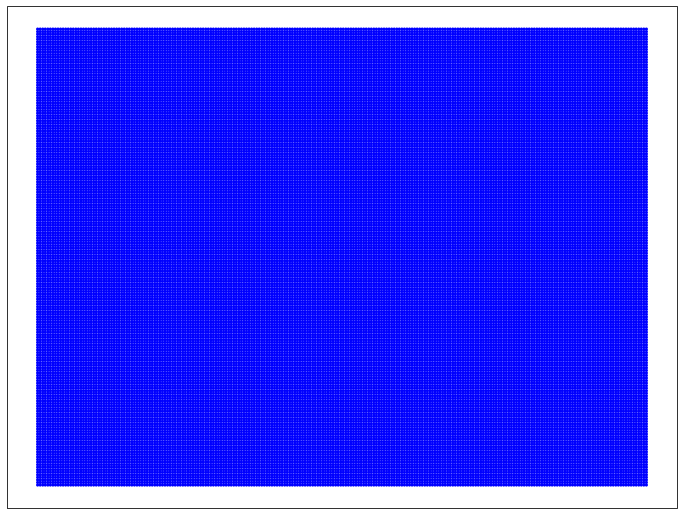

2019 04 05
/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20190405.nc4
(-103.776985, 42.285748, -103.767471, 42.290237)


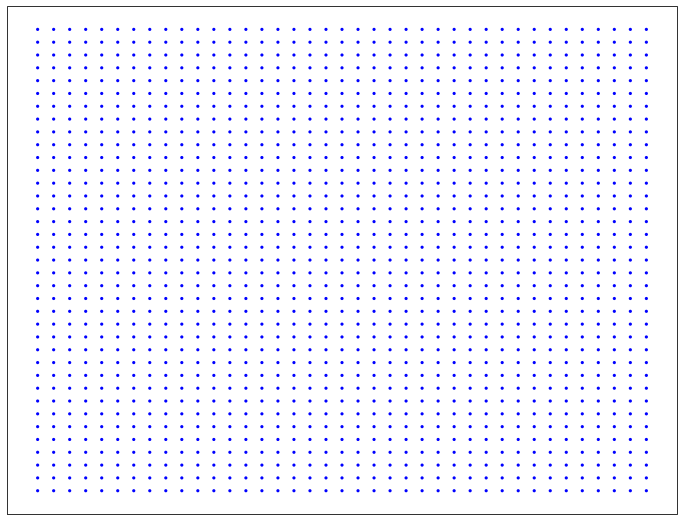

(-103.182228, 38.066891, -103.154724, 38.084461)


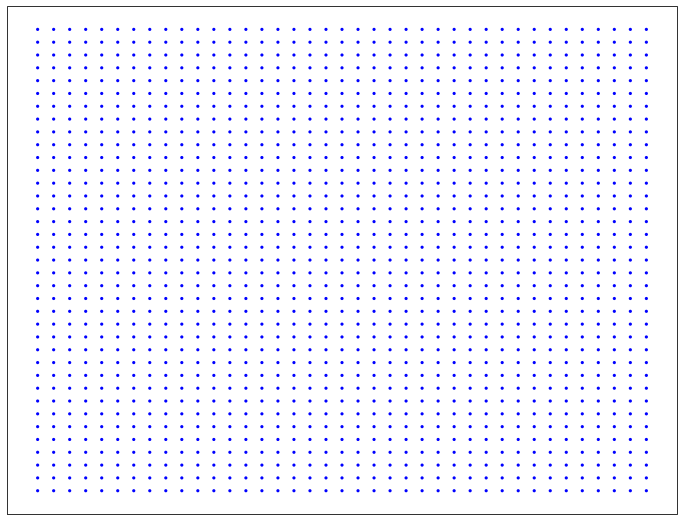

/data2/lthapa/2019/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.20190405.nc4
(-103.776985, 42.285748, -103.767471, 42.290237)


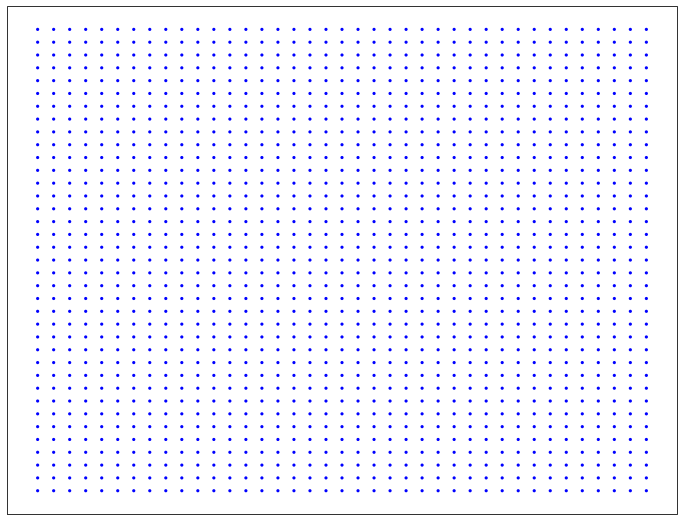

(-103.182228, 38.066891, -103.154724, 38.084461)


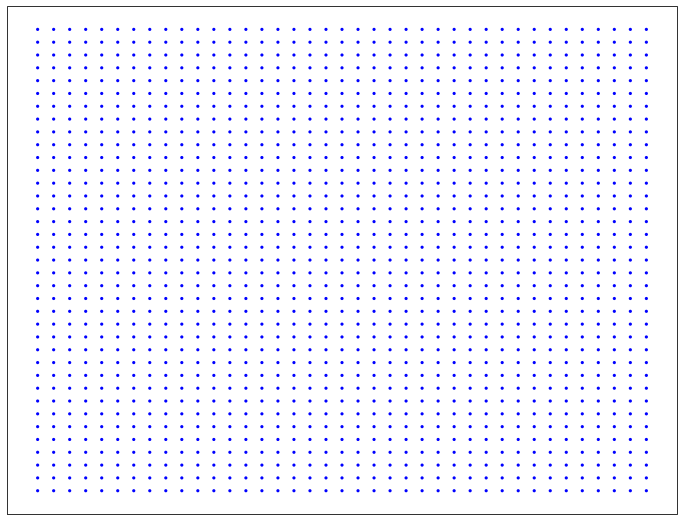

/data2/lthapa/2019/QFED/WESTUS_qfed2.emis_pm25.006.20190405.nc4
(-103.776985, 42.285748, -103.767471, 42.290237)


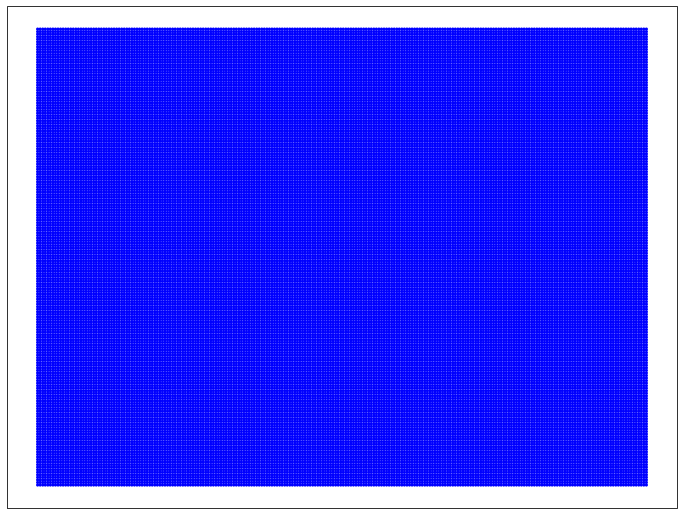

(-103.182228, 38.066891, -103.154724, 38.084461)


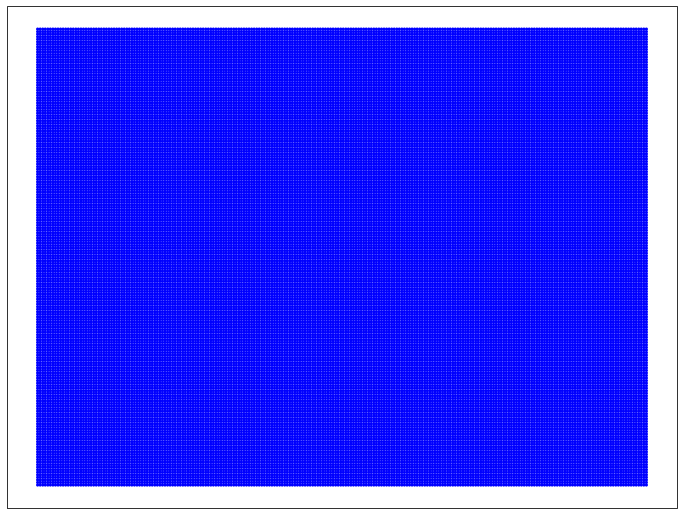

In [165]:
# dictionaries that track the variables, dimensions, times and levels
varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML', 'SPEEDLML', 'PS'], 
        '/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.*.nc4': ['T', 'QV'], 
        '/QFED/WESTUS_qfed2.emis_pm25.006.*.nc4':['biomass']}

#0=lat, 1=lon, 2=time, 3=level 
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time'], 
       '/MERRA2/WESTUS_MERRA2_400.inst3_3d_asm_Np.*.nc4':['lat', 'lon', 'time', 'lev'],
       '/QFED/WESTUS_qfed2.emis_pm25.006.*.nc4':['lat', 'lon', 'time']}
times = {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12, 'T':12, 'QV':12, 'biomass':12}
levels = {'T':[500, 700], 'QV':[700]} 
file_suffix = '.nc4'

#pre-allocate the data frame
num_days = len(fire_attributes)
fire_features = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(num_days), 'Fire Name': np.nan*np.zeros(num_days), 
                             'Current Day': np.nan*np.zeros(num_days), 'Lat Fire': np.nan*np.zeros(num_days), 
                             'Lon Fire': np.nan*np.zeros(num_days), 'Number of VIIRS points': np.nan*np.zeros(num_days),
                            'TLML_12Z': np.nan*np.zeros(num_days), 'QLML_12Z': np.nan*np.zeros(num_days),
                            'SPEEDLML_12Z': np.nan*np.zeros(num_days),'PS_12Z': np.nan*np.zeros(num_days),
                            'T_12Z_700mb': np.nan*np.zeros(num_days),'T_12Z_500mb': np.nan*np.zeros(num_days),
                            'QV_12Z_700mb': np.nan*np.zeros(num_days), 'biomass_12Z': np.nan*np.zeros(num_days),   
                            'geometry': np.nan*np.zeros(num_days)}) # pre-allocate the dataframe
#'fccs': np.nan*np.zeros(num_days),'slp': np.nan*np.zeros(num_days),'asp': np.nan*np.zeros(num_days), 
fire_features['Incident Number'] = fire_attributes['Incident Number'].values
fire_features['Fire Name'] = fire_attributes['Fire Name'].values
fire_features['Current Day'] = fire_attributes['Current Day'].values
fire_features['Lat Fire'] = fire_attributes['Lat Fire'].values
fire_features['Lon Fire'] = fire_attributes['Lon Fire'].values
fire_features['Number of VIIRS points'] = fire_attributes['Number of VIIRS points'].values
fire_features['geometry'] = fire_polygons['geometry'].values

#print(fire_features)
unique_days = np.unique(fire_features['Current Day'].values)
print(len(unique_days))
for dd in range(10): #len(unique_days)):

    date=unique_days[dd]
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    print(yr, mo,dy)
    #find the polygons for the given day

    for i in varis : #loop over the file names
        #get the path to the file
        path = '/data2/lthapa/'+yr+i
        if '*' in path:
            path = path.replace('*', yr+mo+dy)
        if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
            path = path.replace('400', '401')
            
        #load the file in as a netcdf dataset
        print(path)
        dat = nc.Dataset(path)
        ndims = len(dims[i])
        if ndims ==2: #lat and lon
            lat = dat[dims[i][0]][:]
            lon = dat[dims[i][1]][:]
        elif ndims == 3: #lat, lon, and time
            lat = dat[dims[i][0]][:]
            lon = dat[dims[i][1]][:]
            t = dat[dims[i][2]][:]
        elif ndims ==4: #lat,lon,time,and level
            lat = dat[dims[i][0]][:]
            lon = dat[dims[i][1]][:]
            t = dat[dims[i][2]][:]
            lev = dat[dims[i][3]][:]
        if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
        #calculate the areas of the lat/lon grid for the DATASET
        lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)

        inds = np.where(fire_features['Current Day']==date)[0]
        polys = fire_features['geometry'].iloc[inds].values
        for p in range(len(inds)): #loop over the polygons
            poly = polys[p]
            print(poly.bounds)
            UK_mask = shapely.vectorized.contains(poly, lon, lat)
            #UK_mask[15,:] = True
            plt.figure(figsize=(12, 12))
            ax = plt.axes(projection=ccrs.PlateCarree())
            cmap = mcolors.ListedColormap(['blue', 'green'])
            ax.scatter(lon, lat, s=(UK_mask + 0.5) * 20, c=UK_mask + 1, cmap=cmap,
               edgecolor='none', transform=ccrs.PlateCarree())
            plt.show()
            #print('Time elapsed for calculating overlaps for polygon:', toc-tic)
            
        dat.close() 
    
#fire_features

## Helper Functions

In [20]:
#this function calculates the area of each grid in a given grid cell
# LAT and LON should be 2d
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(lat.shape[0]-1),  0:(lat.shape[1])-1] + LAT[1:(lat.shape[0]), 1:(lat.shape[1])])/2
    lon_corners = (LON[0:(lat.shape[0]-1),  0:(lat.shape[1])-1] + LON[1:(lat.shape[0]), 1:(lat.shape[1])])/2
    return lat_corners, lon_corners

In [73]:
# this function calculates the overlap between the given shape (fire_shape) and given grid (LAT, LON). 
#LAT and LON should be 2D

def calculate_overlaps(lat, lon, lat_corners, lon_corners, fire_shape):
    overlaps = np.nan*np.zeros(lat.shape)
    # buffer the fire shape so it has a non zero area
    if fire_shape.area ==0:
        fire_shape = fire_shape.buffer(0.01)
    # find the intersection between the first day's polygon and the  grid
    for ii in range(1, lat.shape[0]-1):
        for jj in range(1, lat.shape[1]-1):
            #print('ctr', lat[ii,jj], lon[ii,jj])
            poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]), (lon_corners[ii, jj],lat_corners[ii, jj]), (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]), (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
            overlap_cell = fire_shape.intersection(poly_cell)
            #overlaps are the fraction of the POLYGON in each grid cell
            overlaps[ii,jj] = overlap_cell.area/fire_shape.area
    
    return overlaps


In [42]:
ii = range(1,lat.shape[0]-1)
jj = range(1, lat.shape[1]-1)
paramlist = list(itertools.product(ii,jj))
print(len(paramlist))

poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]), (lon_corners[ii, jj],lat_corners[ii, jj]), (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]), (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])


1295


In [79]:
 tic = time.time()
for ii in range(1, lat.shape[0]-1):
    for jj in range(1, lat.shape[1]-1):
        poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]), (lon_corners[ii, jj],lat_corners[ii, jj]), (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]), (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
        overlap_cell = poly.intersection(poly_cell)
        #overlaps are the fraction of the POLYGON in each grid cell
        overlaps[ii,jj] = overlap_cell.area/poly.area
toc = time.time()
print(toc-tic)

2.4433631896972656


In [120]:
def calc_overlap_cell(ii, jj, lat_corners, lon_corners, fire_shape):
    #time.sleep(1)
    poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]), (lon_corners[ii, jj],lat_corners[ii, jj]), (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]), (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
    overlap_cell = poly.intersection(poly_cell)
    #overlaps are the fraction of the POLYGON in each grid cell
    overlaps = overlap_cell.area/poly.area
    return overlaps
laps = np.nan*np.zeros((lat.shape[0]-2,lat.shape[1]-2))
#print(laps)

tic = time.time()
laps  = Parallel(n_jobs=4)(delayed(calc_overlap_cell)(i, j, lat_corners, lon_corners, poly) for i in range(1, lat.shape[0]-1) for j in range(1, lat.shape[1]-1))
print(laps)
toc = time.time()
print(toc-tic)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [122]:
print(lat.shape, lat_corners.shape)

(180, 240) (179, 239)


POLYGON ((-114.445518 32.829708, -114.451591 32.830872, -114.461388 32.837395, -114.461533 32.871349, -114.454536 32.874176, -114.445518 32.829708))


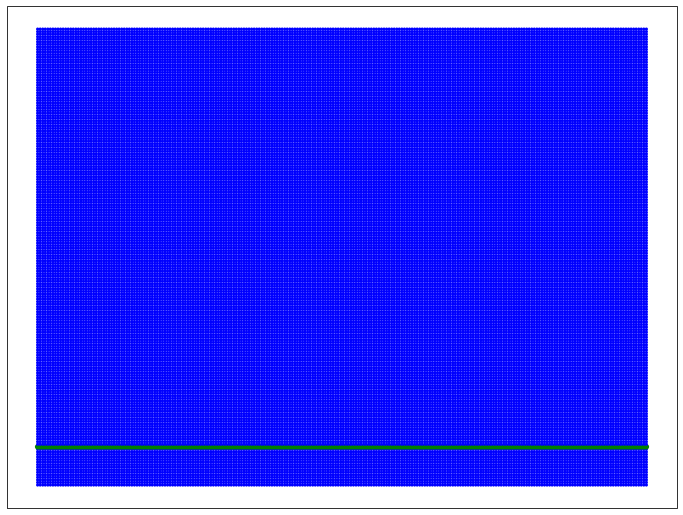

In [156]:
import shapely.vectorized
print(poly)

UK_mask = shapely.vectorized.contains(poly, lat, lon)
UK_mask[15,:] = True
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
cmap = mcolors.ListedColormap(['blue', 'green'])

ax.scatter(lon, lat, s=(UK_mask + 0.5) * 20, c=UK_mask + 1, cmap=cmap,
           edgecolor='none', transform=ccrs.PlateCarree())

#ax.add_geometries([UK_geom], ccrs.PlateCarree(),
#                  facecolor='none', edgecolor='black')

plt.show()

In [143]:

import shapely.geometry as sgeom

import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = list(reader.records())

UK, = [country for country in countries if country.attributes['NAME'] == 'United Kingdom']
UK_geom = UK.geometry
print(UK_geom.bounds)

(-13.69131425699993, 49.90961334800005, 1.7711694670000497, 60.84788646000004)


In [161]:
import numpy as np

y, x = grid_points = np.mgrid[50:59:50j, -8:2:100j] #y is latitude, x is longitude


[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False  True False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False Fal

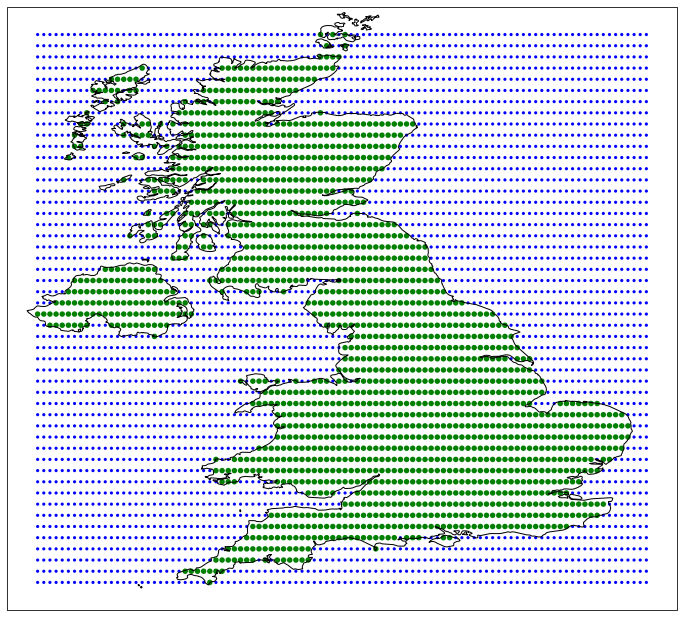

In [163]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs


UK_mask = shapely.vectorized.contains(UK_geom, x, y)
print(UK_mask)
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
cmap = mcolors.ListedColormap(['blue', 'green'])


ax.scatter(x, y, s=(UK_mask + 0.5) * 20, c=UK_mask + 1, cmap=cmap,
           edgecolor='none', transform=ccrs.PlateCarree())

ax.add_geometries([UK_geom], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='black')

plt.show()

In [180]:
polygons = []
for ii in range(1, lat.shape[0]-1):
        for jj in range(1, lat.shape[1]-1):
            #print('ctr', lat[ii,jj], lon[ii,jj])
            polygons.append(Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]), (lon_corners[ii, jj],lat_corners[ii, jj]), (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]), (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])]))
print(len(polygons))
            #if we pre_allocate the 
tic = time.time()
overlaps = [poly.intersection(polygons[i]).area for i in range(len(polygons))]
overlaps = np.reshape(overlaps,(lat.shape[0]-2, lat.shape[1]-2))
toc = time.time()
print(toc-tic)

42364
0.8189787864685059
